# Pyvista testing for platonic solids dataset


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pyvista as pv

# 1. Force static backend to prevent crashing with many subplots
pv.set_jupyter_backend('static')

MIN_R = 5.0
MAX_R = 14.0
MAX_DEG_PER_STEP = 45.0  # Sensitivity

def set_manipulation_view(plotter, actor, origin_state, action_vel):
    """
    origin_state: (d, rot_y, rot_x)
    action_vel:   (v_d, v_y, v_x)
    """
    d0, ry0, rx0 = origin_state
    vd, vy, vx = action_vel

    # 1. Calculate Final State
    # Distance: Clamped to represent Arm Length restriction
    d_final = np.clip(d0 + vd, -1, 1)
    
    # Rotation: Continuous
    ry_final = ry0 + (vy * MAX_DEG_PER_STEP)
    rx_final = rx0 + (vx * MAX_DEG_PER_STEP)

    # 2. Update Camera (Zoom)
    r = ((MAX_R + MIN_R) / 2) + (d_final * (MAX_R - MIN_R) / 2)
    plotter.camera.position = (0, 0, r)
    plotter.camera.focal_point = (0, 0, 0)
    plotter.camera.up = (0, 1, 0)

    # 3. Update Object Orientation
    actor.orientation = [rx_final, ry_final, 0]

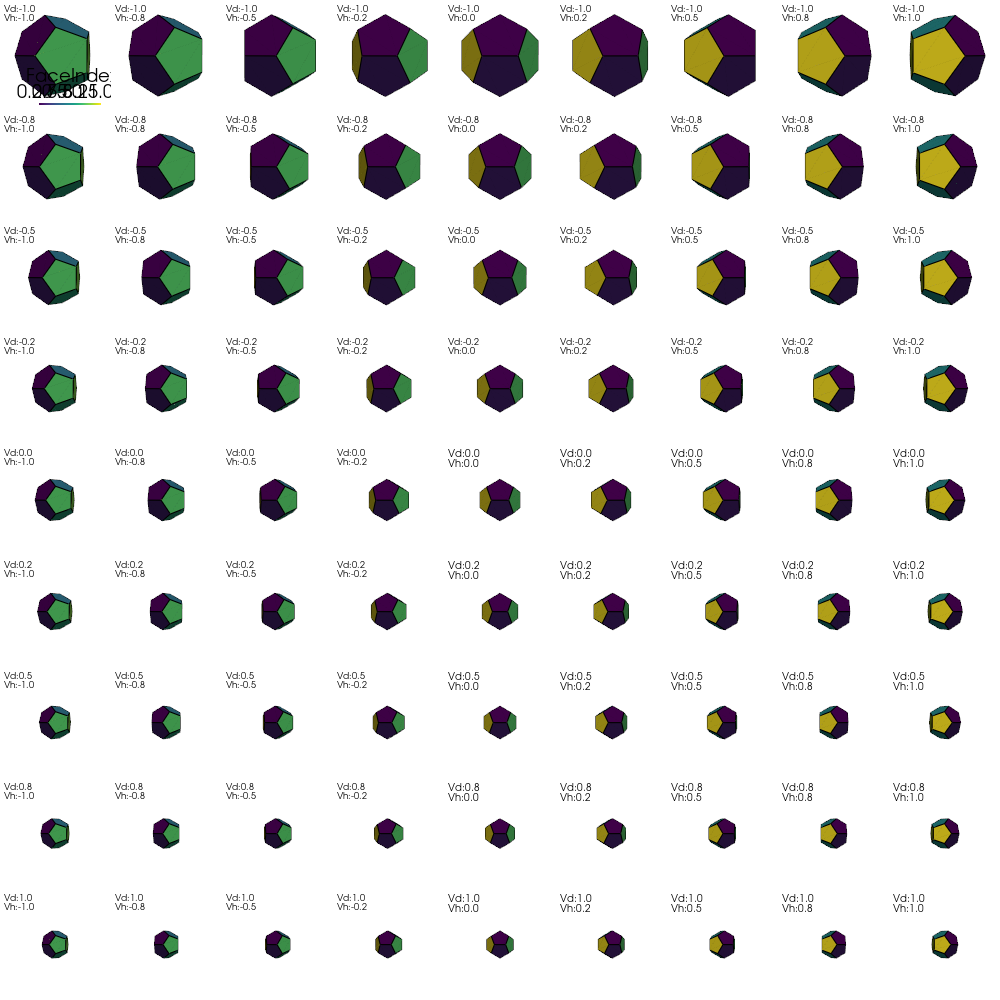

In [3]:
GRID_SIZE = 9

# 1. Origin: (Distance=-1, Horizontal=0.1, Vertical=0.5)
# This means: Start VERY close, slightly rotated right, and tilted down.
ORIGIN = (0.0, 0.1, 0.5) 

# 2. Deltas (Velocities)
# d: Velocity in Distance (Zoom Out -> Zoom In)
# h: Velocity in Rotation (Rotate Left -> Rotate Right)
delta_d_vals = np.linspace(-1, 1, GRID_SIZE) 
delta_h_vals = np.linspace(-1, 1, GRID_SIZE)

pl = pv.Plotter(shape=(GRID_SIZE, GRID_SIZE), border=False, window_size=(1000, 1000))

for i, d_vel in enumerate(delta_d_vals):      # Rows: Distance Velocity
    for j, h_vel in enumerate(delta_h_vals):  # Cols: Horizontal Velocity
        pl.subplot(i, j)
        
        # IMPORTANT: Capture the actor!
        actor = pl.add_mesh(pv.Dodecahedron(), show_edges=True)
        
        # Construct Action: (Dist_Vel, Horiz_Vel, Vert_Vel=0)
        current_diff = (d_vel, h_vel, 0.0)
        
        set_manipulation_view(pl, actor, origin_state=ORIGIN, action_vel=current_diff)
        
        # Label
        pl.add_text(f"Vd:{d_vel:.1f}\nVh:{h_vel:.1f}", font_size=6)

pl.show()

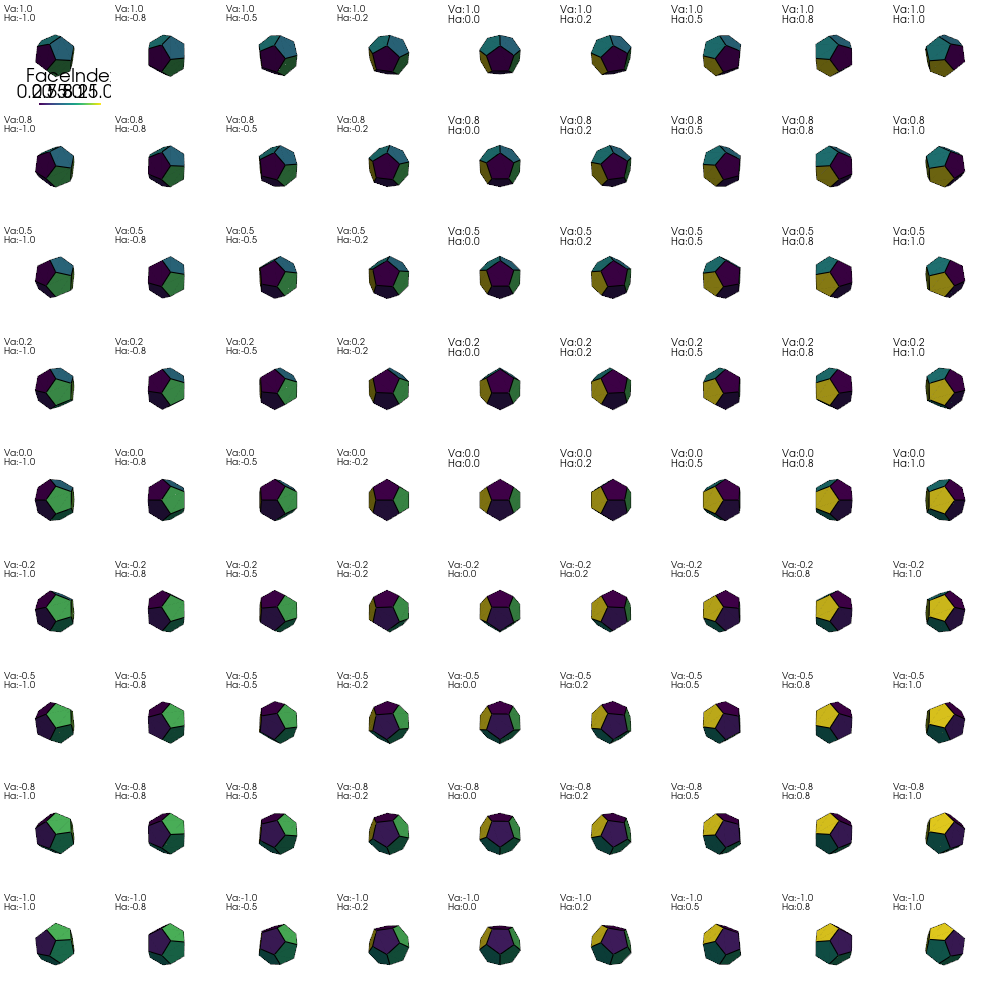

In [4]:
# 1. Origin: Neutral Zoom (0), Facing Front (0, 0)
ORIGIN = (0.0, 0.8, 0.2)
GRID_SIZE = 9

# 2. Actions (Velocities)
# v: Action +1 (Rotate Up/X-axis) -> Action -1 (Rotate Down)
action_v_vals = np.linspace(1, -1, GRID_SIZE)
# h: Action -1 (Rotate Left/Y-axis) -> Action +1 (Rotate Right)
action_h_vals = np.linspace(-1, 1, GRID_SIZE)

pl = pv.Plotter(shape=(GRID_SIZE, GRID_SIZE), border=False, window_size=(1000, 1000))

for i, v_action in enumerate(action_v_vals):      # Rows: Vertical Rotation Action
    for j, h_action in enumerate(action_h_vals):  # Cols: Horizontal Rotation Action
        pl.subplot(i, j)
        
        # Capture the actor to rotate it
        actor = pl.add_mesh(pv.Dodecahedron(), show_edges=True)
        
        # Define the action vector (Zoom=0, Y=h, X=v)
        current_action = (0.0, h_action, v_action)
        
        set_manipulation_view(pl, actor, origin_state=ORIGIN, action_vel=current_action)
        
        # Label: Va = Vertical Action, Ha = Horizontal Action
        pl.add_text(f"Va:{v_action:.1f}\nHa:{h_action:.1f}", font_size=6)

pl.show()

In [5]:
from typing import Tuple, Iterator
import random as rd

def closed_loop_trajectory(
    length: int, 
) -> Iterator[Tuple[float, float, float]]:
    """
    Generates a trajectory that returns to the initial state 
    at the end of each cycle.
    """
    velocities = []
    v_d, v_y, v_x = 0.0, 0.0, 0.0
    cum_d, cum_y, cum_x = 0.0, 0.0, 0.0
    if length % 2 != 0:
        length += 1  # Make length even
    half_length = length // 2

    for i in range(half_length):
        #  Set a final step to return to origin
        if i == half_length - 1:

            v_d = -cum_d
            v_y = -cum_y
            v_x = -cum_x 

        # Standard random steps
        else:
            v_d = rd.uniform(-1, 1)
            v_y = rd.uniform(-1, 1)
            v_x = rd.uniform(-1, 1)

        cum_d += v_d
        cum_y += v_y
        cum_x += v_x

        velocities.append((v_d, v_y, v_x))
    
    for vel in velocities:
        yield vel
        yield vel

In [6]:
vels = []
for vel in closed_loop_trajectory(length=5):
    print(vel)
    vels.append(vel)

sum_d = sum(v[0] for v in vels)
sum_y = sum(v[1] for v in vels)
sum_x = sum(v[2] for v in vels)

(0.7939885777192663, 0.2458074523738314, -0.40689466560053855)
(0.7939885777192663, 0.2458074523738314, -0.40689466560053855)
(-0.008543602790212823, -0.6350069325508334, 0.869779818521484)
(-0.008543602790212823, -0.6350069325508334, 0.869779818521484)
(-0.7854449749290535, 0.389199480177002, -0.46288515292094545)
(-0.7854449749290535, 0.389199480177002, -0.46288515292094545)


In [7]:
sum_d, sum_y, sum_x

(0.0, 0.0, 0.0)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random



ID_TO_SHAPE = {
    0: 'tetrahedron',
    1: 'cube',
    2: 'octahedron',
    3: 'dodecahedron',
    4: 'icosahedron',
}

def visualize_samples(shard_path, num_samples=3):
    try:
        data = np.load(shard_path)
    except FileNotFoundError:
        print(f"File not found: {shard_path}")
        return

    images = data['images']      # Shape: (B, T, H, W, C)
    shape_ids = data['shape_ids'] # Shape: (B,)
    actions = data['actions']     # Shape: (B, T-1, 3)
    
    total_trajs = images.shape[0]
    traj_len = images.shape[1]
    
    print(f"Loaded Shard: {shard_path}")
    print(f"Total Trajectories: {total_trajs} | Length: {traj_len} frames")
    print("-" * 60)

    indices = random.sample(range(total_trajs), num_samples)

    for idx in indices:
        traj_imgs = images[idx]
        s_id = shape_ids[idx]
        shape_name = ID_TO_SHAPE.get(s_id, "Unknown")
        
        step = max(1, traj_len // 10)
        frames_to_show = traj_imgs[::step]
        
        fig, axes = plt.subplots(1, len(frames_to_show), figsize=(20, 2.5))
        fig.suptitle(f"Trajectory #{idx} | Shape: {shape_name} | showing every {step}. frame", fontsize=14)
        
        for i, ax in enumerate(axes):
            ax.imshow(frames_to_show[i])
            ax.axis('off')
            ax.set_title(f"t={i*step}")
            
        plt.show()



Loaded Shard: ../data/level1_easy/train/shard000.npz
Total Trajectories: 10 | Length: 11 frames
------------------------------------------------------------


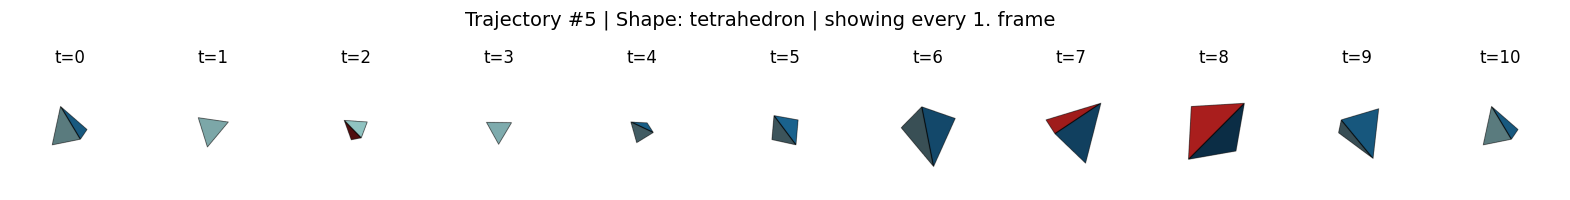

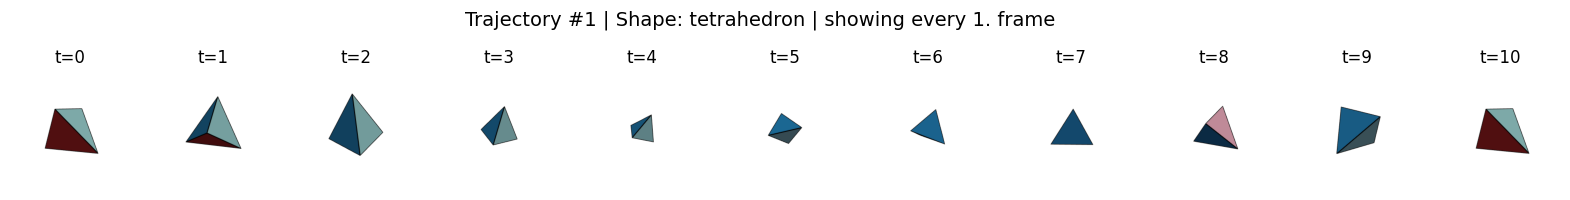

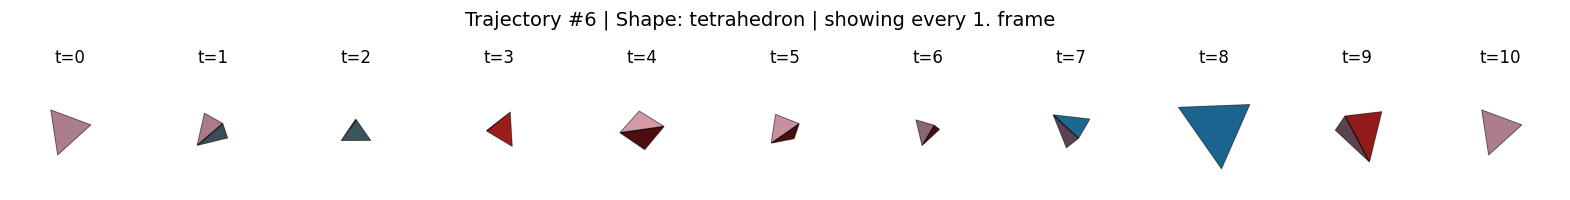

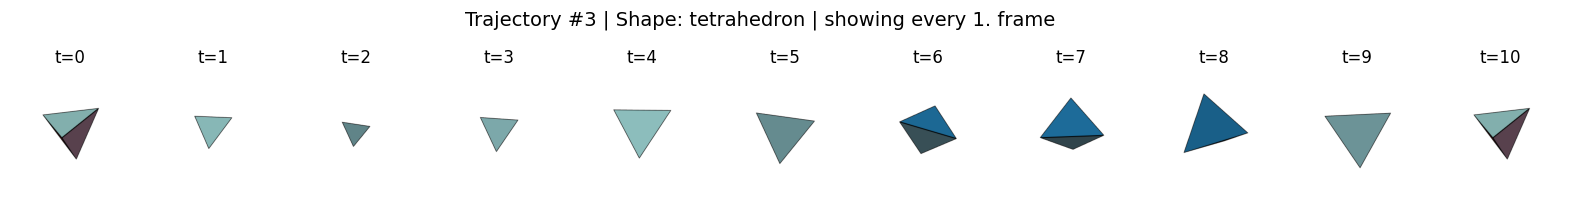

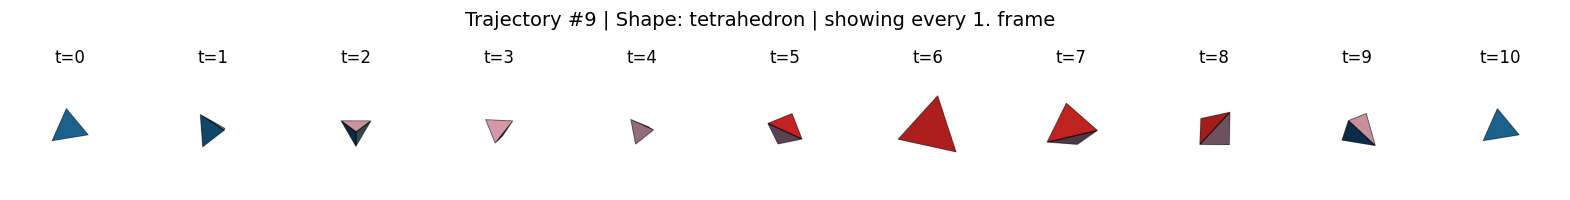

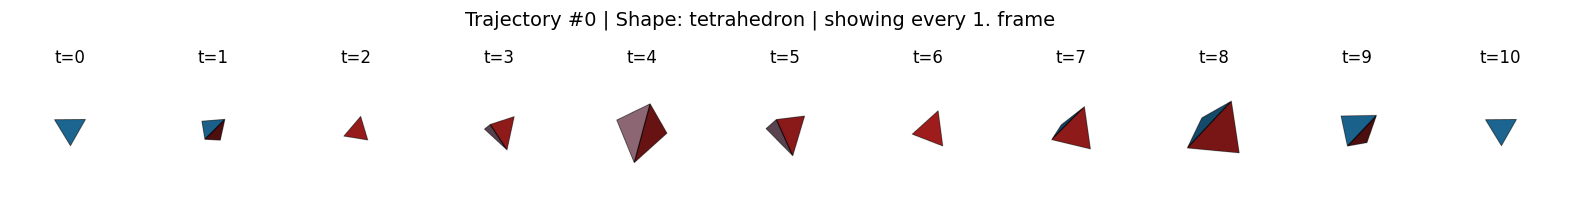

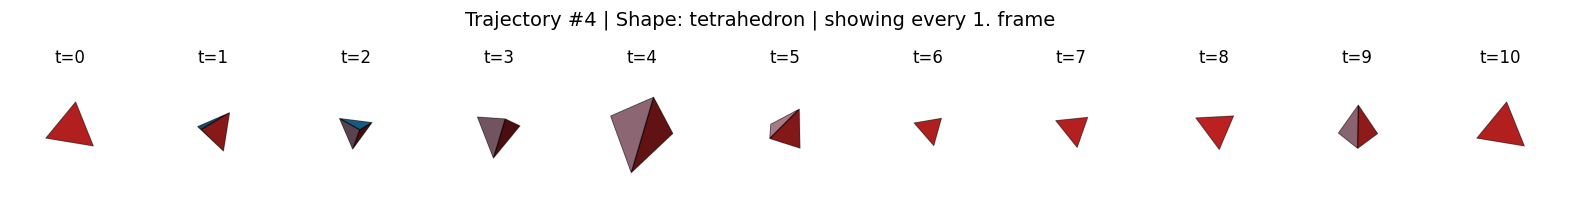

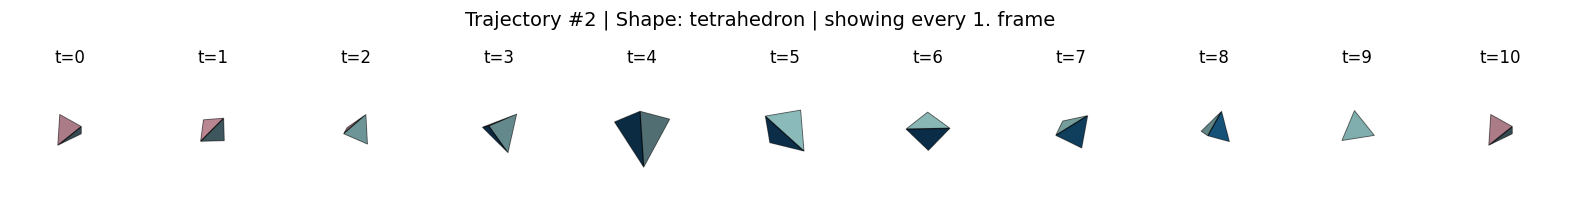

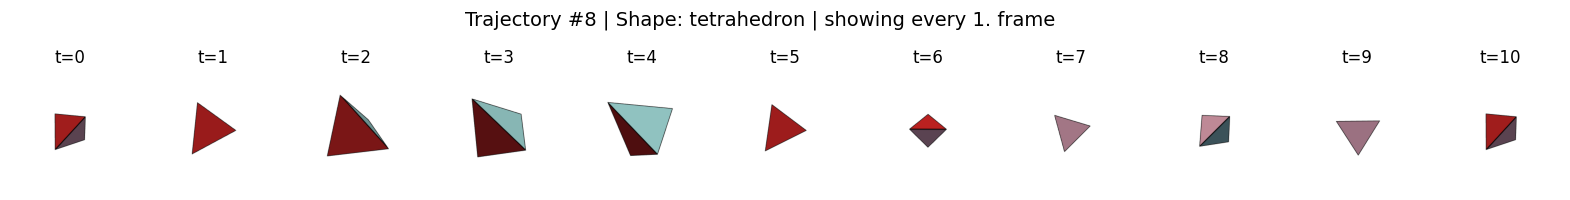

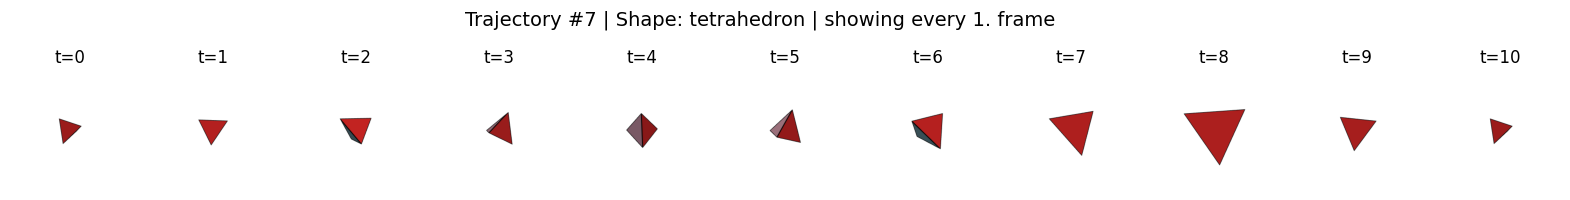

In [9]:
visualize_samples("../data/level1_easy/train/shard000.npz" , num_samples=10)

Loaded Shard: ../data/medium_data/shard000.npz
Total Trajectories: 10 | Length: 31 frames
------------------------------------------------------------


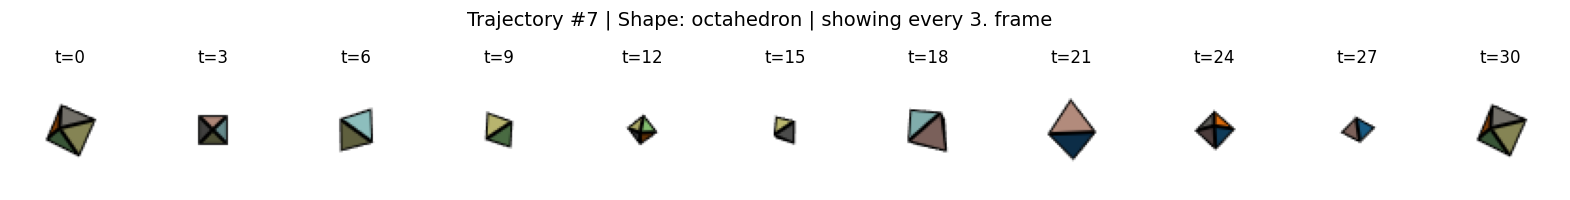

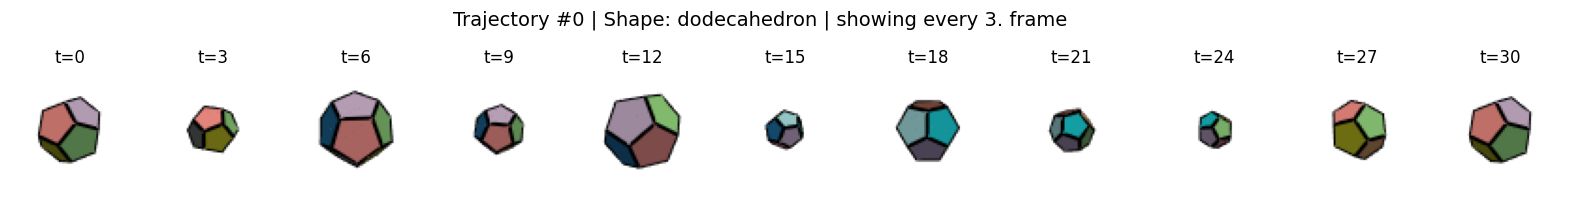

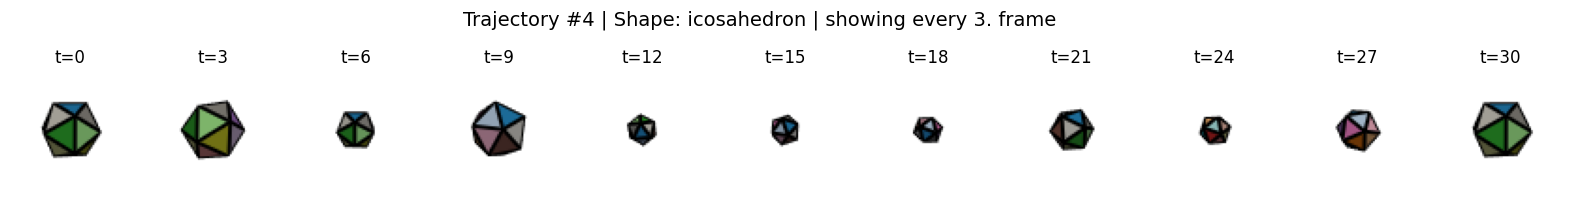

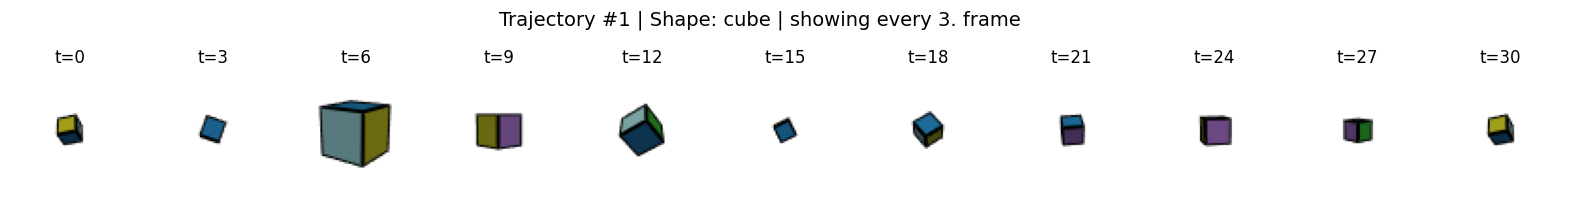

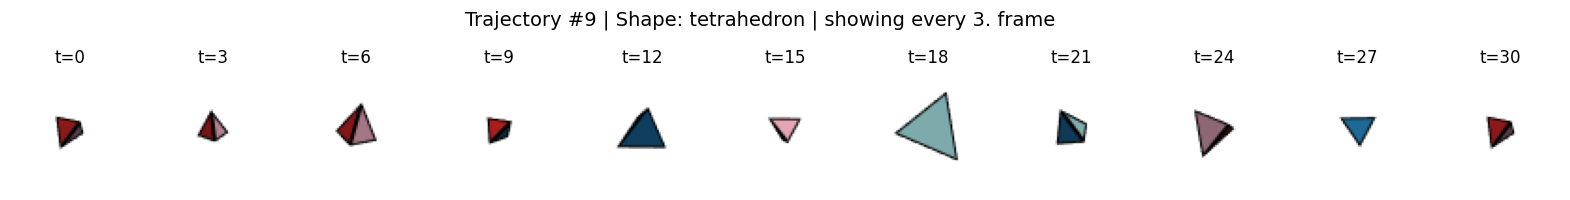

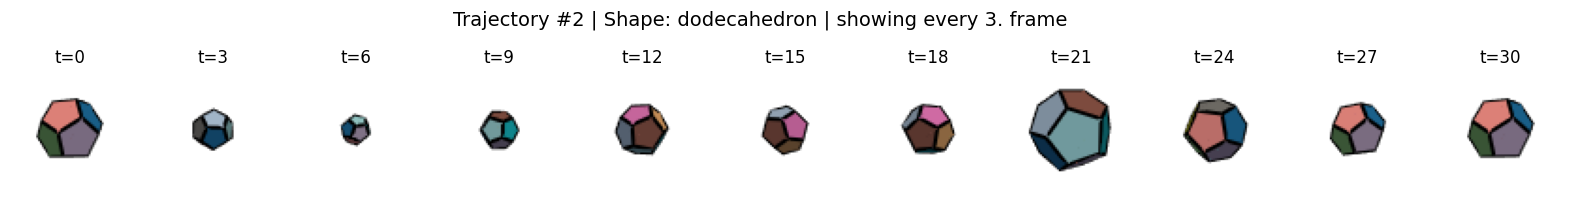

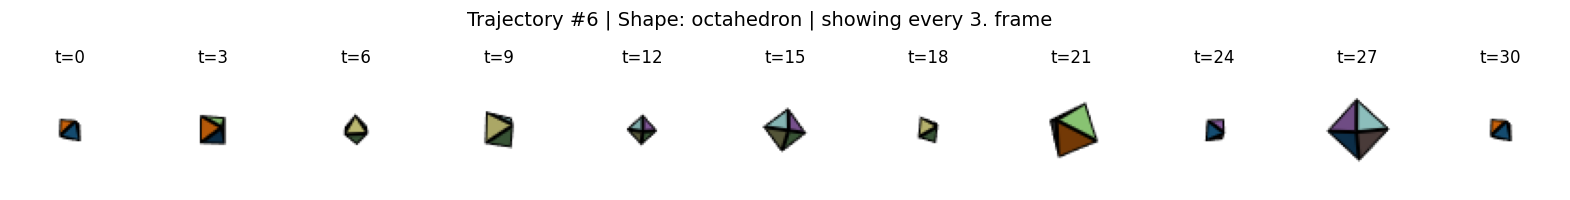

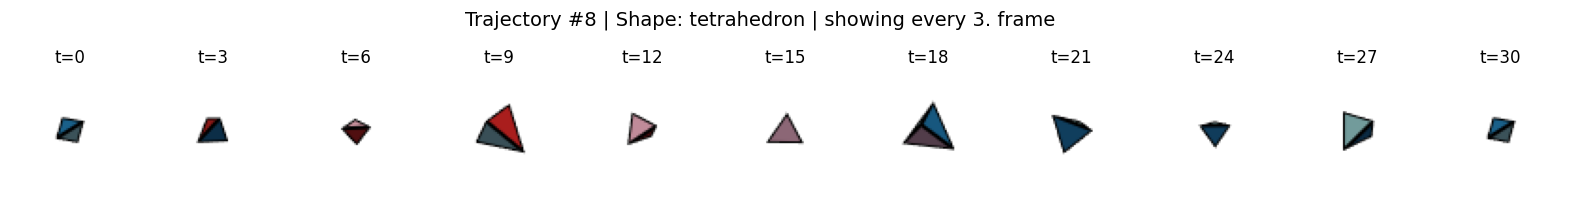

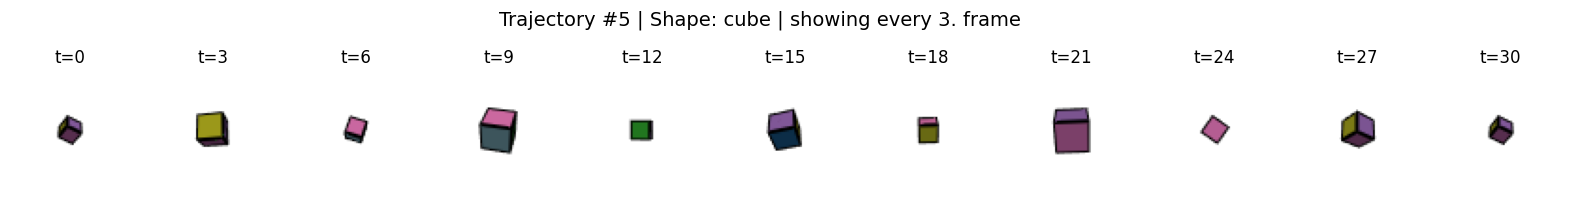

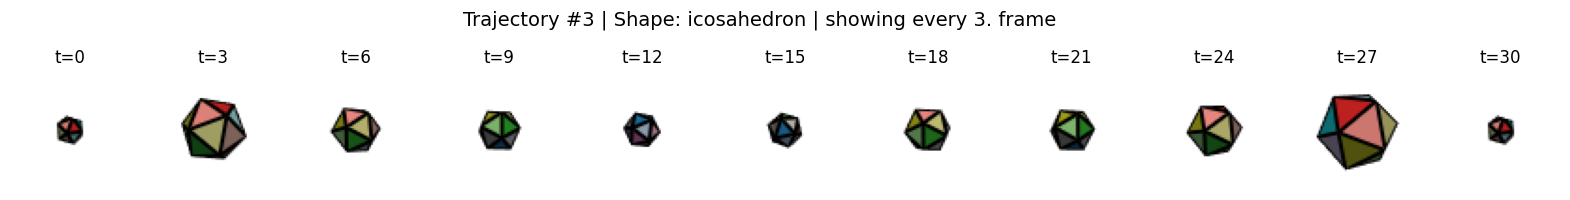

In [54]:
visualize_samples("../data/medium_data/shard000.npz" , num_samples=10)

In [47]:
import os
import numpy as np

def read_platonic_solids_dataset(dataset_dir: str) -> PlatonicSolidsDataset:
    # Sort to ensure deterministic ordering of data
    shard_files = sorted([
        os.path.join(dataset_dir, f) 
        for f in os.listdir(dataset_dir) 
        if f.endswith('.npz') or f.endswith('.npy')
    ])

    all_images = []
    all_actions = []
    all_states = []

    for file_path in shard_files:
        # allow_pickle=True handles both .npz and pickled dicts in .npy
        shard_data = np.load(file_path, allow_pickle=True)
        
        all_images.append(shard_data['images'])
        all_actions.append(shard_data['actions'])
        all_states.append(shard_data['states'])

    combined_data = {
        "images": np.concatenate(all_images, axis=0),
        "actions": np.concatenate(all_actions, axis=0),
        "states": np.concatenate(all_states, axis=0)
    }

    return PlatonicSolidsDataset(combined_data)

In [49]:
dataset = read_platonic_solids_dataset("../data/level1_easy/train/")

In [50]:
dataset[0]["images"].shape, dataset[0]["actions"].shape, dataset[0]["states"].shape

(torch.Size([11, 256, 256, 4]), torch.Size([10, 3]), torch.Size([11, 3]))

In [53]:
# Sample dataloader

import torch
from torch.utils.data import DataLoader


train_loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
)

# Test the output shapes
batch = next(iter(train_loader))
for k, v in batch.items():
    print(f"{k}: {v.shape}")

images: torch.Size([32, 11, 256, 256, 4])
actions: torch.Size([32, 10, 3])
states: torch.Size([32, 11, 3])
